# Import Libraries


In [ ]:
%reload_ext autoreload
%autoreload 2

import ast
import mlflow
import missingno as msno
import numpy as np
import pandas as pd
import ppscore as pps
import plotly.express as px
import pendulum
import seaborn as sns
import sys
import xgboost as xgb

from loguru import logger
from matplotlib import pyplot as plt
from pathlib import Path
from pycaret import regression
from scipy.stats import uniform, randint, yeojohnson
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, TransformedTargetRegressor
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score, max_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, quantile_transform
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from typing import Union, Dict
from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot, PredictionError

sys.path.append(str(Path.cwd().parent))
from settings.params import MODEL_PARAMS

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# Settings


In [ ]:
log_fmt = "<green>{time:YYYY-MM-DD HH:mm:ss.SSS!UTC}</green> | <level>{level: <8}</level> | <cyan>{name}</cyan>:<cyan>{function}</cyan>:<cyan>{line}</cyan> - {message}"
logger.configure(handlers=[{"sink": sys.stderr, "format": log_fmt}])

TARGET_NAME = MODEL_PARAMS["TARGET_NAME"]
REPORTS_DIR = "../reports"
SEED = 42

In [ ]:
mlflow.set_tracking_uri(uri="http://localhost:8080")

# Data Collection


In [ ]:
data2015 = pd.read_csv('../datasets/2015-building-energy-benchmarking.csv')
data2016 = pd.read_csv('../datasets/2016-building-energy-benchmarking.csv')

In [ ]:
data2015.info()

In [ ]:
data2016.info()

## Harmonize datasets


The 2015 data is not aligned with 2016. Need to populate missing columns in one file vs the other. Let's re-arrange 2015


In [ ]:
set(data2015) - set(data2016)

In [ ]:
# 2016 missing in 2015
set(data2016) - set(data2015)

In [ ]:
ast.literal_eval(data2015['Location'][1])

In [ ]:
data2015['Latitude']=data2015['Location'].apply(lambda l : ast.literal_eval(l)['latitude'])
data2015['Longitude']=data2015['Location'].apply(lambda l : ast.literal_eval(l)['longitude'])
data2015['State']=data2015['Location'].apply(lambda l :  ast.literal_eval(ast.literal_eval(l)['human_address'])['state'])
data2015['ZipCode']=data2015['Location'].apply(lambda l :  ast.literal_eval(ast.literal_eval(l)['human_address'])['zip'])
data2015['City']=data2015['Location'].apply(lambda l :  ast.literal_eval(ast.literal_eval(l)['human_address'])['city'])
data2015['Address']=data2015['Location'].apply(lambda l :  ast.literal_eval(ast.literal_eval(l)['human_address'])['address'])

In [ ]:
data2015['TotalGHGEmissions']=data2015['GHGEmissions(MetricTonsCO2e)']
data2015['GHGEmissionsIntensity']=data2015['GHGEmissionsIntensity(kgCO2e/ft2)']

In [ ]:
# 2015 and 2016 now aligned and ready to be combined
set(data2015) - set(data2016)

In [ ]:
set(data2016) - set(data2015)

Some columns are only available in the 2015 dataset. Some of them do not provide useful information and the others are largely incomplete. We are going to drop them in order to have a perfectly harmonized dataset.


In [ ]:
data2015.drop(['Location','GHGEmissions(MetricTonsCO2e)','GHGEmissionsIntensity(kgCO2e/ft2)', 'SPD Beats','Seattle Police Department Micro Community Policing Plan Areas',
               'Zip Codes','OtherFuelUse(kBtu)','2010 Census Tracts','City Council Districts', 'Comment'], axis='columns', inplace=True)

In [ ]:
data2016.drop(['Comments'], axis='columns', inplace=True)

### Align data types between the 2 files


In [ ]:
pd.DataFrame([data2015.dtypes,data2016.dtypes])

In [ ]:
data2015[['Latitude','Longitude','ZipCode']]=data2015[['Latitude','Longitude','ZipCode']].astype('float64')

In [ ]:
data2015['DefaultData'] = data2015['DefaultData'].map({'Yes' : True, 'No' : False}).head()

### Combine the 2 datasets


In [ ]:
data = pd.concat([data2015,data2016], axis=0, ignore_index=True)

In [ ]:
# Columns 
data.info()

### Harmonize values


In [ ]:
for key in list(data.keys()):
    if data[key].nunique()<20:
        print(key,'------->', data[key].unique())
    else:
        print(key, '------->',data[key].nunique())

In [ ]:
data['Neighborhood'].replace('Delridge', 'DELRIDGE', inplace=True)
data['Neighborhood'].replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE', inplace=True)
data['Neighborhood'].replace('North', 'NORTH', inplace=True)
data['Neighborhood'].replace('Northwest', 'NORTHWEST', inplace=True)
data['Neighborhood'].replace('Central', 'CENTRAL', inplace=True)
data['Neighborhood'].replace('Ballard', 'BALLARD', inplace=True)

In [ ]:
data['City'].replace('SEATTLE', 'Seattle', inplace=True)
data['ComplianceStatus'].replace('Not Compliant', 'Non-Compliant', inplace=True)

In [ ]:
data.describe()

In [ ]:
data.info()

# Exploratory Data Analysis


## Missing values


In [ ]:
msno.bar(data)

In [ ]:
data.isna().sum()

In [ ]:
data['ComplianceStatus'].value_counts()

After reading the descriptions of each of the columns present in the dataset, we can make the following observations about some notable missing data:

- SecondLargestPropertyUseType & ThirdLargestPropertyUseType contain lots of missing values. When they are absent we can interpret that as the corresponding building not having a second or third use type.
- Outlier is a column which indicates if the building's measures correspond to a high or low outlier(true outliers in summary). We interpret the absence of value as indicating that the building is supposedly normal.
- YearsEnergyStarCertified is a list of years for which the building has been certified EnergyStar. Nan values mean that the building has never had the certification.
- Comments is a column which should contain comments by a building owner or an agent to provide context about the building's energy use. No comments were made in the dataset. We can already drop that column from our dataset.


## Target Analysis


In [ ]:
data[TARGET_NAME].describe()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))

sns.histplot(data[TARGET_NAME], color='r', kde=True, ax=axes[0])
axes[0].set_title('Distribution of energy consumption')

sns.histplot(np.log(data[TARGET_NAME]), color='b', kde=True, ax=axes[1])
axes[1].set_title('Distribution of energy consumption in $log$ scale')
axes[1].set_xscale('log')

- Some of the buildings investigated have zero energy use which does not make sense in this context. An analysis on the compliance of some of the data shows that almost all of those buildings' data are marked as non-compliant, missing or Default Data in the dataset. That means we cannot take that data into account.
- The distribution of the target variable is highly skewed. Converting it to a log scale allows for a normal distribution, which can be more easily exploited by the model to be built.


In [ ]:
# Compliance of the rows for which SiteEnergyUse is zero
data[data[TARGET_NAME] == 0]['ComplianceStatus']

In [ ]:
fig = px.box(data, y="SiteEnergyUse(kBtu)")
fig.show()

The box plot illustrates the distribution of SiteEnergyUse(kBtu). The majority of the data points cluster near the lower end of the energy use spectrum, indicating relatively low energy consumption for most entries. However, there are several prominent outliers that deviate significantly from this cluster:

- There are a few data points that exhibit exceptionally high energy use, with values reaching up to 800 million kBtu.
- These high outliers are considerably distant from the main cluster, indicating that certain sites have much higher energy consumption compared to the rest.
- The presence of these outliers suggests variability in the dataset, which could be due to differences in site size, operational hours, or inefficiencies.
- These outliers need to be further investigated to understand the underlying causes and to determine if they should be included in the analysis or addressed separately. That analysis will be done when cleaning the data and we will use the Outlier column available in the dataset to determine which ones are true outliers and which ones are incoherent values.


In [ ]:
# df = data.copy()
# z_scores = np.abs((df["SiteEnergyUse(kBtu)"] - df["SiteEnergyUse(kBtu)"].mean()) / df["SiteEnergyUse(kBtu)"].std())
# outliers = df[z_scores >= 3]
# len(outliers)
# false_outliers = outliers[outliers['Outlier'].isna()]
# len(false_outliers)

## Data Analysis


### Numerical Features


In [ ]:
numerical_features = data.select_dtypes(include="number").columns
numerical_data = data[numerical_features]
logger.info(f"Categorical features:\n {sorted(numerical_features)}\n")

In [ ]:
numerical_data.head()

#### Data distributions


In [ ]:
num_cols = 3
num_rows = (len(numerical_features) + num_cols - 1) // num_cols  # calculate the number of rows needed
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols*6, num_rows*5))  # adjust figsize as needed

for i, col in enumerate(numerical_features):
    row = i // num_cols
    col_pos = i % num_cols
    sns.histplot(numerical_data[col], kde=False, ax=axes[row, col_pos])
    axes[row, col_pos].set_title(col)

plt.tight_layout()
plt.show()

#### Scatter Plots


In order to have meaningful visualizations, we need to limit the data to building's whose energy use is between the 5th and 95th percentiles.


In [ ]:
lower_percentile = data[TARGET_NAME].quantile(0.05)
upper_percentile = data[TARGET_NAME].quantile(0.95)

In [ ]:
limited_numerical_data = data[(data[TARGET_NAME] >= lower_percentile) & (data[TARGET_NAME] <= upper_percentile)]

In [ ]:
# Number of plots per row
plots_per_row = 3

# Calculate number of rows needed
num_rows = len(numerical_features) // plots_per_row + (len(numerical_features) % plots_per_row > 0)

# Create subplots
fig, axs = plt.subplots(num_rows, plots_per_row, figsize=(6 * plots_per_row, 5 * num_rows))

# Flatten axs for easy iteration
axs = axs.flatten()

# Plot each numerical column against the target variable
for i, column in enumerate(numerical_features):
    sns.scatterplot(x=limited_numerical_data[column], y=limited_numerical_data[TARGET_NAME], ax=axs[i])
    axs[i].set_title(f'{column} vs {TARGET_NAME}')

fig.subplots_adjust(hspace=0.3, wspace=0.2)

#### Correlation Matrix


In [ ]:
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

#### Observations:

- All values related to energy are highly correlated to the target column SiteEnergyUse(kbtu). All those columns correspond to data that is obtained with the energy consumption statement. They can cause data leakage when used as features for the model

- The column NumberOfBuildings has some zeros. For this column the value should be at least 1

- The column NumberOfFloors also has zeros where its minimum value should be 1

- The column NumberOfFloors

- Some properties can already be classified as being unhelpful to the future model since they do not provide any relevant or quantifiable information about the building in itself: OSEBuildingID, DataYear, ZipCode, CouncilDistrictCode

- Instead of using directly YearBuilt, we are going to transform it into an Age column to simplify its relationship to the target variable and avoid data leakage.

- Since the site energy use is known, there is no need for having an absolute value for the consumption of Electricity, Steam or Gas. We are going to replace the corresponding columns with the ratio of the consumption of those types of energy on the total energy use.

- In the same way, instead of using absolute values for the largest use types GPAs, we can use the ratios on the total GPA.


### Categorical Features


In [ ]:
categorical_features = data.select_dtypes(include=["object", "bool"]).columns
categorical_data = data[categorical_features]
categorical_data[TARGET_NAME] = data[TARGET_NAME]
logger.info(f"Categorical features:\n {sorted(categorical_features)}\n")

In [ ]:
categorical_data.loc[:, categorical_features].describe()

In [ ]:
categorical_data.loc[:, categorical_features].info()

#### Box plots


Before creating the box plots, some features can already be filtered out since they obviously do not provide any information relevant to energy use and they would make the visualization more difficult to analyze


In [ ]:
categorical_features = list(filter(lambda x: x not in ["TaxParcelIdentificationNumber", "PropertyName", "Address", "City", "State", "ListOfAllPropertyUseTypes"], categorical_features))

In [ ]:
categorical_features

In the same manner as before, we are going to limit the data in order to have meaningful visualizations


In [ ]:
len(set(data['LargestPropertyUseType'].unique()) - set(data['PrimaryPropertyType'].unique()))

In [ ]:
data['PrimaryPropertyType'].unique()

In [ ]:
data['LargestPropertyUseType'].unique()

In [ ]:
lower_percentile = data[TARGET_NAME].quantile(0.05)
upper_percentile = data[TARGET_NAME].quantile(0.95)

limited_categorical_data = categorical_data[(categorical_data[TARGET_NAME] >= lower_percentile) & (categorical_data[TARGET_NAME] <= upper_percentile)]

# Plot each categorical column against the target variable
for i, column in enumerate(categorical_features):
    fig = px.box(data_frame=limited_categorical_data, x=column, y=TARGET_NAME, title=f'{column} by {TARGET_NAME}')
    fig.show()

#### Observations

- PrimaryPropertyType column contains data redundant to what's in LargestPropertyUseType. We will work only with the second one which contains a lot more classes. That could help the model make better choices.
- The columns BuildingType, PrimaryPropertyType and the ones concerning the property use types seem to have an effect on the target column.
- Some columns can already be classified as not providing valuable information for our problem: TaxParcelIdentificationNumber, PropertyName, Address, City and State
- DefaultData, Outlier and ComplianceStatus do not really provide information that could be relevant to knowing the energy usage of a site. They will mostly help in order ot understand better the data at hand and clean it accordingly
- ListOfAllPropertyUseTypes contains data that will be mostly redundant to what we have in LargestPropertyUseType, SecondLargestPropertyUseType and ThirdLargestPropertyUseType. There are very few buildings that have up to a third use, so we suppose that buildings that have 4 or more uses are even more rare. Since this column contains information redundant to other columns and does not provide more information than we have, we will not use it for our model.
- YearsEnergyStarCertified cannot be used since it will cause data leakage. That information may not be known at the time of prediction.


# Data Preparation


## Handling Missing Values and Cleaning Data


In [ ]:
data.isna().sum()

We can populate some of the the missing information in some columns with simple strategies


In [ ]:
# If there are no second and third property usage types, replace NaN with "No Use"
data[['ThirdLargestPropertyUseType', 'SecondLargestPropertyUseType']] = data[['ThirdLargestPropertyUseType', 'SecondLargestPropertyUseType']].fillna('No Use')

# If there are no second and third property usage types, replace GFA with 0
data[['ThirdLargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA']] = data[['ThirdLargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA']].fillna(0, )

# If LargestPropertyUseType is missing, replace with No Information
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].fillna('No information')

In [ ]:
# If the row is neither a high or low outlier, replace missing value with 'normal'
data['Outlier'].replace(np.nan,'normal', inplace=True)

We are now going to drop the rows of the dataset marked as being non-compliant. When a record is indicated as such, it means that the information collected about it is erronous. We cannot feed that data to our model.


In [ ]:
indexes_to_drop = data[data['ComplianceStatus'] == 'Non-Compliant'].index
data.drop(indexes_to_drop, inplace=True, axis=0)

In [ ]:
data.isna().sum()

Next we can drop the rows for which we the compliance status indicate missing data. For those rows, the energy consumption is zero on the dataset.


In [ ]:
indexes_to_drop = data[data['ComplianceStatus'] == 'Missing Data'].index
data.drop(indexes_to_drop, inplace=True, axis=0)

The are also other rows for which energy consumption is 0 or Nan. Some records indicate 0 electricity consumption or have a missing value for that column. They are going to be dropped from the dataset.


In [ ]:
# Remaining records indicating no energy usage
data[data[TARGET_NAME] == 0]

In [ ]:
# Records indicating no electricity usage
data[data['Electricity(kWh)'] == 0]

In [ ]:
# Records having a missing value for electricity usage
data[data['Electricity(kWh)'].isna()]

In [ ]:
index_to_drop = data[(data[TARGET_NAME] == 0) | (data[TARGET_NAME].isna()) | (data['Electricity(kBtu)'] == 0) | (data['Electricity(kBtu)']).isna()].index
print(index_to_drop)
print(f'there are {len(index_to_drop)} samples with 0 energy consumption reported -> Drop')
data.drop(index_to_drop, inplace=True, axis=0)

In [ ]:
data.isna().sum()

In this step, we are going to correct the apparent incoherences in the columns NumberOfFloors and NumberOfBuildings. As shown below, some records have values of 0 for them. We'll also replace the missing values for them.


In [ ]:
# NumberOfFloors Value counts
data["NumberofFloors"].value_counts()

In [ ]:
# NumberOfBuildings Value Counts
data["NumberofBuildings"].value_counts()

In [ ]:
# Replace missing values and zeros in NumberOfFloors with the most representative value
data['NumberofFloors'].replace(np.nan, 3, inplace=True)
data['NumberofFloors'].replace(0, 3, inplace=True)

In [ ]:
# Replace missing values and zeros in NumberOfBuildings with the most representative value
data['NumberofBuildings'].replace(np.nan, 1, inplace=True)
data['NumberofBuildings'].replace(0, 1, inplace=True)

Since the building types present in the data are mostly for housing and offices, we can replace the missing values in LargestPropertyUseTypeGFA with the corresponding values of PropertyGFABuilding(s)


In [ ]:
data[data['LargestPropertyUseTypeGFA'].isna()]

In [ ]:
for index in range(len(data)):
    if np.isnan(data.iloc[index]['LargestPropertyUseTypeGFA']):
        data['LargestPropertyUseTypeGFA'].iloc[index] = data['PropertyGFABuilding(s)'].iloc[index]

In [ ]:
data.isna().sum()

### Removing Outliers


In order to remove outliers, we are going to use the z-score. The information contained in the Outlier column will help us detect the false outliers from the true ones. Only records whose z_score for energy usage is more than 3 and not indicated as true outliers will be dropped.


In [ ]:
target = data[TARGET_NAME]
z_scores = np.abs((target - target.mean()) / target.std())

In [ ]:
data = data[(z_scores < 3) & (data['Outlier'] == 'normal')]

## Feature Engineering


We are going to create new features based on the original ones.

- Instead of working with YearBuilt, it will be more interesting to work with building's ages
- We cannot use the different types of source energy consumption (Electricity, Gas and Steam) since they are linked to the target, but we can use the ratio of each type of energy.
- In the same way, instead of using absolute values for PropertyGFAParking, PropertyGFABuilding(s), LargestPropertyUseTypeGFA, second and third, we can work with relative values.


In [ ]:
# Changing YearBuilt column to Age Column with Age = 2016 - YearBuilt
data["Age"] = 2016 - data["YearBuilt"]

# Replace PropertyGFAParking, PropertyGFABuilding, LargestPropertyUseTypeGFA with values relative to PropertyGFATotal
columns = ["PropertyGFAParking", "PropertyGFABuilding(s)", "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"]
for column in columns:
    ratio_column = column + "Ratio"
    data[ratio_column] = data[column]/data["PropertyGFATotal"]
    

# Create columns for energy type proportion and replace absolute energy value with intensity (kBtu/sf)
columns = ["SteamUse(kBtu)", "Electricity(kBtu)", "NaturalGas(kBtu)"]
for column in columns:
    # Calculating for each type of energy its ratio
    ratio_column = column.replace("(kBtu)", "Ratio")
    data[ratio_column] = data[column]/data["SiteEnergyUse(kBtu)"]

## Remove irrelevant and redundant Data


We are going to remove all the columns that we judged to be unhelpful for the model and redundant data. We will also remove the columns from which came the ones we created in the last step.


In [ ]:
columns = ["DataYear", "City", "State", "DefaultData", "OSEBuildingID", "PrimaryPropertyType", "YearsENERGYSTARCertified", 
            "Address", "CouncilDistrictCode", "PropertyName", "ComplianceStatus", "TaxParcelIdentificationNumber",
            "ZipCode", "ENERGYSTARScore", "SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)", "SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)", 
            "SiteEnergyUseWN(kBtu)", "NaturalGas(therms)", "Electricity(kWh)", "TotalGHGEmissions", "ListOfAllPropertyUseTypes",
            "SteamUse(kBtu)", "Electricity(kBtu)", "NaturalGas(kBtu)", "LargestPropertyUseTypeGFA", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA",
            "GHGEmissionsIntensity", "PropertyGFAParking", "PropertyGFABuilding(s)", "YearBuilt"]

data = data.drop(columns, axis=1)

In [ ]:
data.info()

## Feature Selection


We need to have SiteEnergyUse in log scale in order to have a normal distribution.


In [ ]:
df = data.copy()
df["SiteEnergyUse(kBtu)"] = np.log(df["SiteEnergyUse(kBtu)"])

In [ ]:
pps_predictors = pps.predictors(df=df, y="SiteEnergyUse(kBtu)", random_seed=MODEL_PARAMS["SEED"])
pps_predictors

In [ ]:
# Check if there are invalid pps scores computed
pps_predictors.is_valid_score.value_counts()

In [ ]:
# Get features whose pps > MIN_PPS
FEATURE_NAMES = pps_predictors.loc[pps_predictors.ppscore >= MODEL_PARAMS["MIN_PPS"], "x"].values
set(FEATURE_NAMES)

# Modeling


## Train/Test Split


In [ ]:
FEATURES = list(FEATURE_NAMES)

x_train, x_test, y_train, y_test = train_test_split(data.loc[:, FEATURES], data[TARGET_NAME], test_size=MODEL_PARAMS["TEST_SIZE"], random_state=SEED)

logger.info(f"\nX train: {x_train.shape}\nY train: {y_train.shape}\n"
            f"X test: {x_test.shape}\nY test: {y_test.shape}")

## Training


In [ ]:
df = x_train.copy()
df[TARGET_NAME] = np.log(y_train)

In [ ]:
exp_reg = regression.setup(df, target=TARGET_NAME, max_encoding_ohe=200, log_experiment=True, experiment_name="building-energy-prediction-training", train_size=0.8)
regression.set_config('seed', SEED)
regression.remove_metric('MAPE')
regression.remove_metric('MSE')
regression.remove_metric('RMSLE')

In [ ]:
best_threes_model = regression.compare_models(n_select=3)

In [ ]:
mlflow.end_run()

## Fine-Tuning


In [ ]:
def define_pipeline(numerical_transformer: list,
                    categorical_transformer: list,
                    estimator: Pipeline,
                    target_transformer: bool = False,
                    **kwargs: dict) -> Pipeline:
    """ Define pipeline for modeling

    Args:
        **kwargs:

    Returns:
        Pipeline: sklearn pipeline
    """
    numerical_transformer = make_pipeline(*numerical_transformer)

    categorical_transformer = make_pipeline(*categorical_transformer)

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numerical_transformer, make_column_selector(dtype_include=["number"])),
            ("cat", categorical_transformer, make_column_selector(dtype_include=["object", "bool"])),
        ],
        remainder="drop",  # non-specified columns are dropped
        verbose_feature_names_out=False,  # will not prefix any feature names with the name of the transformer
    )
    # Append regressor to preprocessing pipelineregreregffdffdffd.
    # Now we have a full prediction pipeline.
    if target_transformer:
        model_pipe1 = Pipeline(steps=[("preprocessor", preprocessor),
                                     ("estimator", estimator)])
        model_pipe = TransformedTargetRegressor(regressor=model_pipe1,
                                                func=np.log,
                                                inverse_func=np.exp)
    else:
        model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("estimator", estimator)])
        
    # logger.info(f"{model_pipe}")
    return model_pipe

In [ ]:
ESTIMATOR_PARAMS = {
    ExtraTreesRegressor.__name__: {
        "estimator": ExtraTreesRegressor(),
        "params": {
            'regressor__estimator__n_estimators': randint(10, 125),
            'regressor__estimator__max_depth': np.arange(1, 10, 1),
            'regressor__estimator__min_samples_split': np.arange(2, 10, 1),
            'regressor__estimator__min_samples_leaf': [1, 2, 3, 4],
        }
    },
    RandomForestRegressor.__name__: {
        "estimator": RandomForestRegressor(),
        "params": {
            'regressor__estimator__n_estimators': randint(10, 125),
            'regressor__estimator__max_depth': np.arange(1, 10, 1),
            'regressor__estimator__min_samples_split': np.arange(1, 10, 1),
            'regressor__estimator__min_samples_leaf': [1, 2, 3, 4]
        }
    },
    xgb.XGBRegressor.__name__: {
        "estimator": xgb.XGBRegressor(),
        "params": {
            'regressor__estimator__n_estimators': randint(10, 125),
            'regressor__estimator__max_depth': np.arange(1, 11, 1),
            'regressor__estimator__learning_rate': uniform(0.01, 0.2),
            'regressor__estimator__subsample': uniform(0.8, 1),
            'regressor__estimator__colsample_bytree': uniform(0.8, 1),
            'regressor__estimator__gamma': uniform(0, 0.2)
        }
    }
}

In [ ]:
CURRENT_DATE = pendulum.now()

search_cvs = {}

def rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

def mlflow_log_search(search):
    best_params = search.best_params_

    # Log the best parameters
    mlflow.log_params(best_params)

    # Log the best metric
    mlflow.log_metric("R2", search.best_score_)

    # Log the model
    mlflow.sklearn.log_model(search.best_estimator_, "model")

scoring = {'r2': make_scorer(r2_score),
          'rmse': make_scorer(rmse, greater_is_better=False),
          'mae': make_scorer(mean_absolute_error, greater_is_better=False)}

# Create an experiment if not exists
exp_name = "building-energy-prediction-tuning-sklearn"
experiment = mlflow.get_experiment_by_name(exp_name)
if not experiment:
    experiment_id = mlflow.create_experiment(exp_name)
else:
    experiment_id = experiment.experiment_id

with mlflow.start_run(run_name=f"Session-{CURRENT_DATE.strftime('%Y%m%d_%H%m%S')}", experiment_id=experiment_id) as parent_run:
    for estimator_name, settings in ESTIMATOR_PARAMS.items():
        with mlflow.start_run(run_name=estimator_name, nested=True, experiment_id=experiment_id):  
            estimator = settings["estimator"]
            param_grid = settings["params"]
            pipeline = define_pipeline(numerical_transformer=[SimpleImputer(strategy="median"),RobustScaler()],
                            categorical_transformer=[SimpleImputer(strategy="constant", fill_value="undefined"), OneHotEncoder(drop="if_binary", handle_unknown="ignore")],
                            target_transformer=True,
                            estimator=estimator
                        ) 
            random_search = RandomizedSearchCV(
                estimator=pipeline,  # Instantiate the estimator
                param_distributions=param_grid,
                scoring=scoring,
                refit='r2',
                n_iter=200,  # Adjust the number of iterations as needed
                cv=5,  # Adjust the number of cross-validation folds as needed
                n_jobs=-1  # Use all available cores
            )
            random_search.fit(x_train, y_train)
            search_cvs[estimator_name] = random_search

            mlflow.log_param("Estimator", estimator_name)
            mlflow_log_search(random_search)
mlflow.end_run()

## Model Evaluation


We are going to evaluate both trained and fine-tuned models to see which one we are going to pick as the final model.


In [ ]:
def eval_metrics(y_actual: Union[pd.DataFrame, pd.Series, np.ndarray],
                 y_pred: Union[pd.DataFrame, pd.Series, np.ndarray]
                 ) -> Dict[str, float]:
    """Compute evaluation metrics.

    Args:
        y_actual: Ground truth (correct) target values
        y_pred: Estimated target values.

    Returns:
        Dict[str, float]: dictionary of evaluation metrics.
            Expected keys are: "rmse", "mae", "r2", "max_error"

    """
    metrics = dict()
    # Calculate Root mean squared error, named rmse
    metrics['rmse'] = mean_squared_error(y_actual, y_pred) ** 0.5
    # Calculate mean absolute error, named mae
    metrics['mae'] = mean_absolute_error(y_actual, y_pred)
    # Calculate R-squared: coefficient of determination, named r2
    metrics['r2'] = r2_score(y_actual, y_pred)
    # Calculate max error: maximum value of absolute error (y_actual - y_pred), named maxerror
    metrics['maxerror'] = max_error(y_actual, y_pred)
    # Return a dictionary
    return metrics

In [ ]:
trained_models = [define_pipeline(numerical_transformer=[SimpleImputer(strategy="median"),RobustScaler()],
                            categorical_transformer=[SimpleImputer(strategy="constant", fill_value="undefined"), OneHotEncoder(drop="if_binary", handle_unknown="ignore")],
                            target_transformer=True,
                            estimator=model
                        ) for model in best_threes_model]
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=MODEL_PARAMS["TEST_SIZE"], random_state=SEED)
trained_models = [model.fit(x_train, y_train) for model in trained_models]
trained_models = {item.regressor.steps[-1][1].__class__.__name__: item for item in trained_models}

In [ ]:
# Obtaining best_models after fine-tuning
tuned_models = { f"Tuned{estimator_name}": search_cv.best_estimator_ for estimator_name, search_cv in search_cvs.items()}

In [ ]:
exp_name = "building-energy-prediction-evaluation"
experiment = mlflow.get_experiment_by_name(exp_name)
if not experiment:
    experiment_id = mlflow.create_experiment(exp_name)
else:
    experiment_id = experiment.experiment_id

def evaluate_models(estimators, x_train, x_test, y_train, y_test):
    # Dict of R2 scores for the estimators
    r2_scores = {}
    with mlflow.start_run(run_name=f"Session-{CURRENT_DATE.strftime('%Y%m%d_%H%m%S')}", experiment_id=experiment_id):
        for estimator_name, estimator in estimators.items():
            with mlflow.start_run(run_name=estimator_name, nested=True, experiment_id=experiment_id): 
                y_train_pred = estimator.predict(x_train)
                y_test_pred = estimator.predict(x_test)

                train_metrics = eval_metrics(y_train, y_train_pred)
                test_metrics = eval_metrics(y_test, y_test_pred)

                # Add the R2 score of the model to the global dict
                r2_scores[estimator_name] = test_metrics['r2']

                # Log the regressor parameters
                mlflow.log_params(estimator.regressor.steps[-1][1].get_params())

                # Log the best metric
                mlflow.log_metrics(test_metrics)

                # Log the model
                mlflow.sklearn.log_model(search.best_estimator_, "model")

                logger.info(f"""{estimator_name} performance \n{pd.DataFrame({'train': train_metrics, 'test': test_metrics}).T}""")
    max(r2_scores.items(), key=lambda item: item[1])

mlflow.end_run()

models = {}
models.update(trained_models)
models.update(tuned_models)

best_estimator, score = evaluate_models(models, x_train, x_test, y_train, y_test)

logger.info(f"""{best_estimator} is the best estimator found for this problem with an R2 score of {score}""")

### Prediction Error Plot


In [447]:
def prediction_error_plot(estimators, x_train, x_test, y_train, y_test):
    for estimator_name, estimator in estimators.items():
        visualizer = PredictionError(estimator, is_fitted="auto", identity=True, bestfit=True)
        visualizer.fit(x_train, y_train)
        visualizer.score(x_test, y_test)
        print(f"Prediction plot for estimator {estimator_name}")
        visualizer.show()

Prediction plot for estimator ExtraTreesRegressor


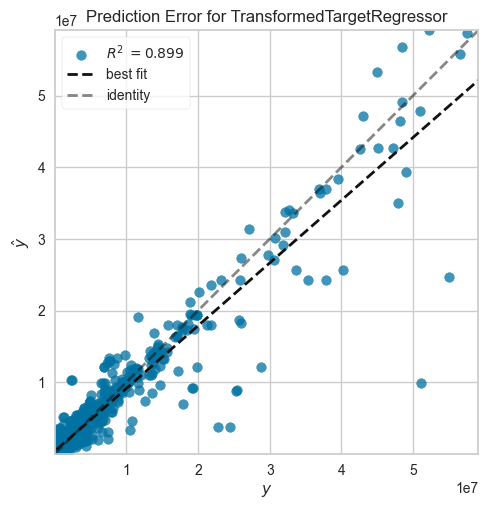

Prediction plot for estimator RandomForestRegressor


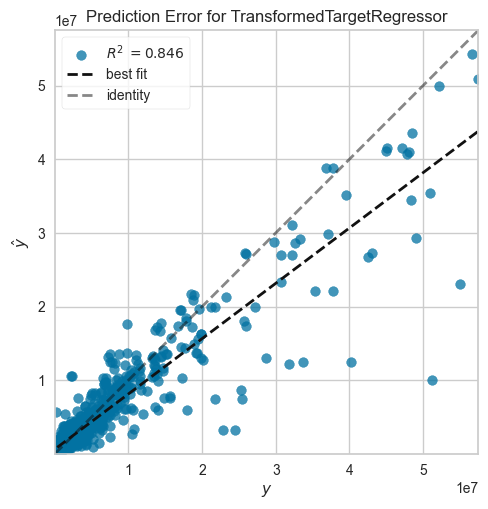

Prediction plot for estimator XGBRegressor


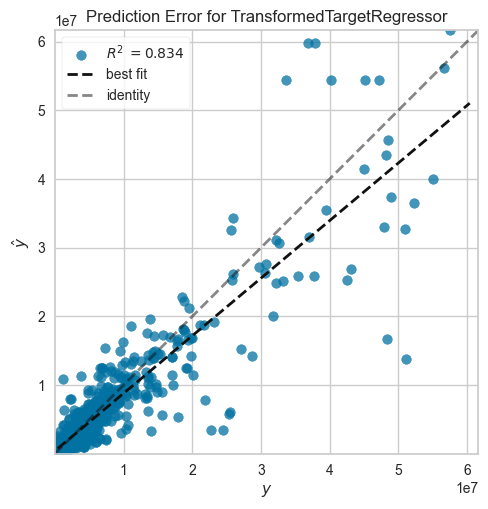

Prediction plot for estimator TunedExtraTreesRegressor


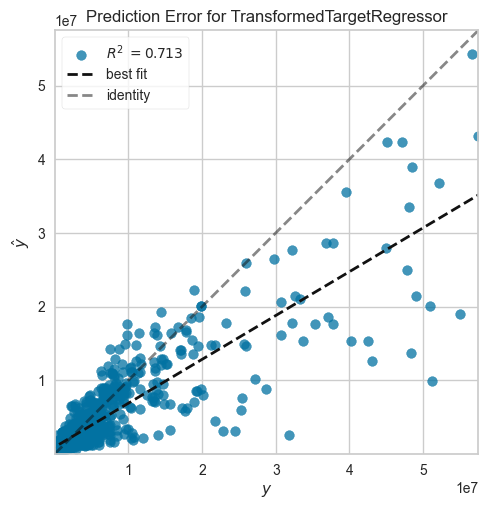

Prediction plot for estimator TunedRandomForestRegressor


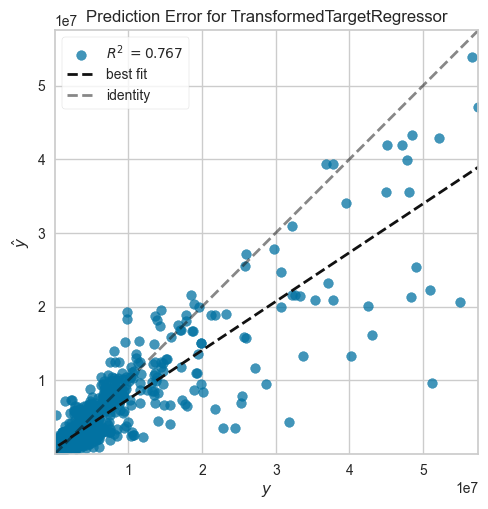

Prediction plot for estimator TunedXGBRegressor


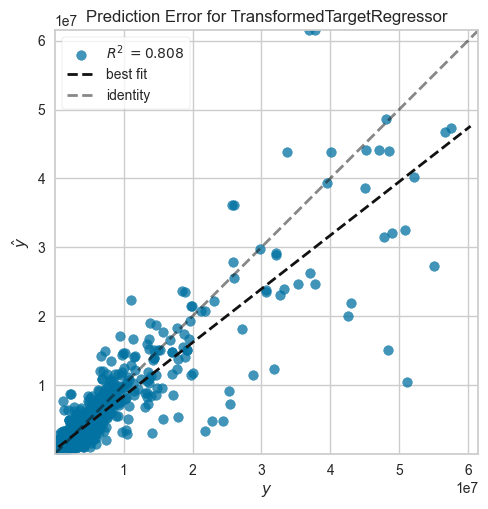

In [448]:
prediction_error_plot(models, x_train, x_test, y_train, y_test)

### Residual Plot


In [449]:
def residual_plot(estimators, x_train, x_test, y_train, y_test):
    for estimator_name, estimator in estimators.items():
        visualizer = ResidualsPlot(estimator, is_fitted="auto")
        visualizer.fit(x_train, y_train)
        visualizer.score(x_test, y_test)
        print(f"Residual plot for estimator {estimator_name}")
        visualizer.show()

Residual plot for estimator ExtraTreesRegressor


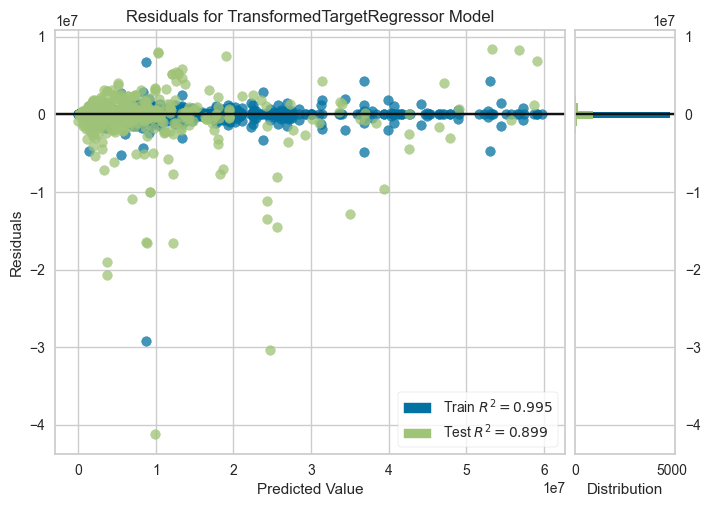

Residual plot for estimator RandomForestRegressor


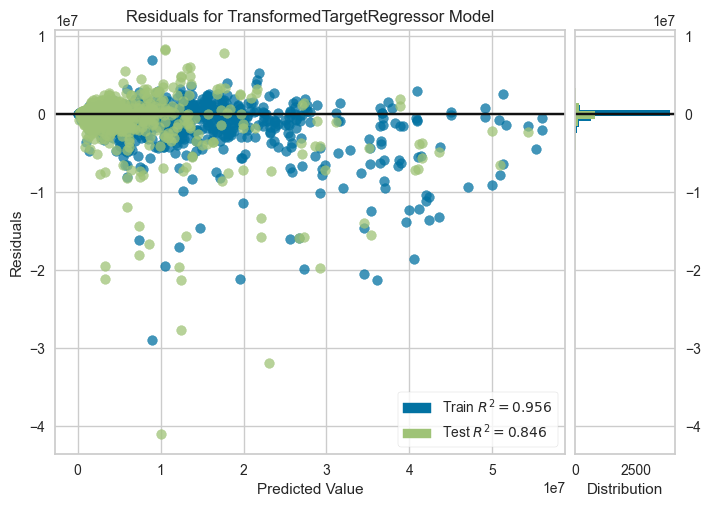

Residual plot for estimator XGBRegressor


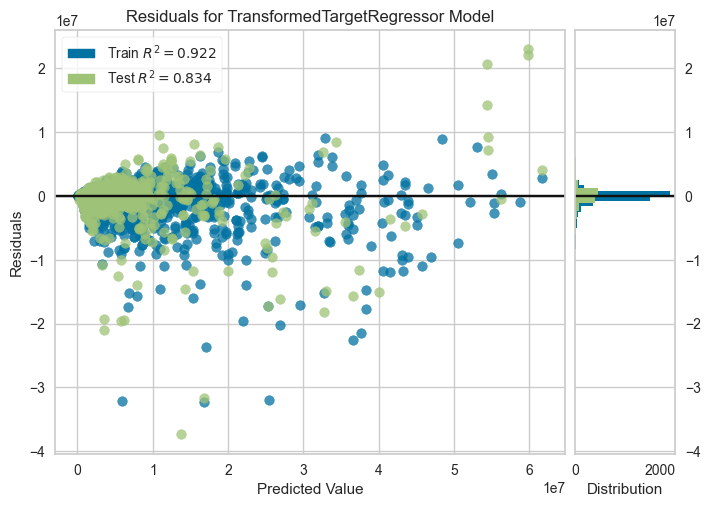

Residual plot for estimator TunedExtraTreesRegressor


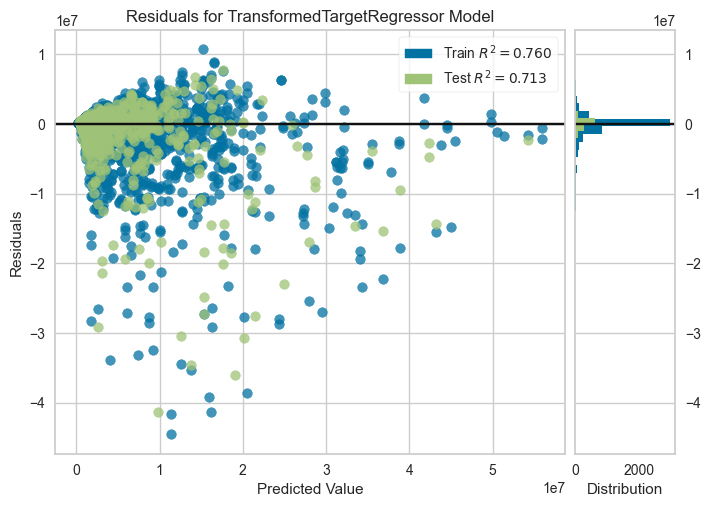

Residual plot for estimator TunedRandomForestRegressor


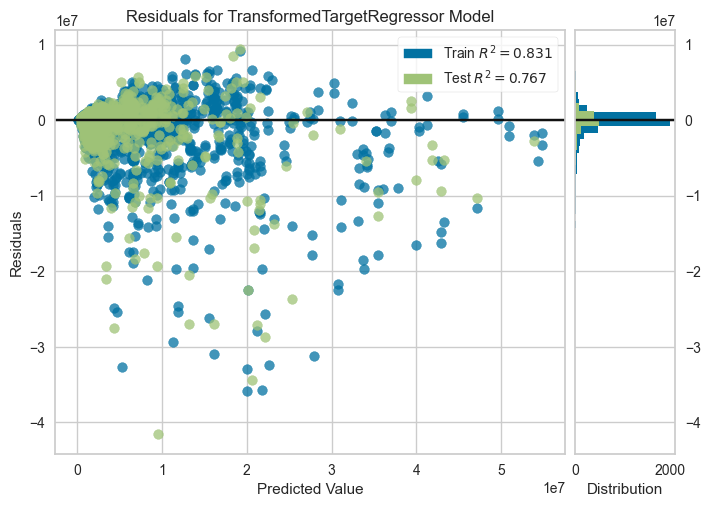

Residual plot for estimator TunedXGBRegressor


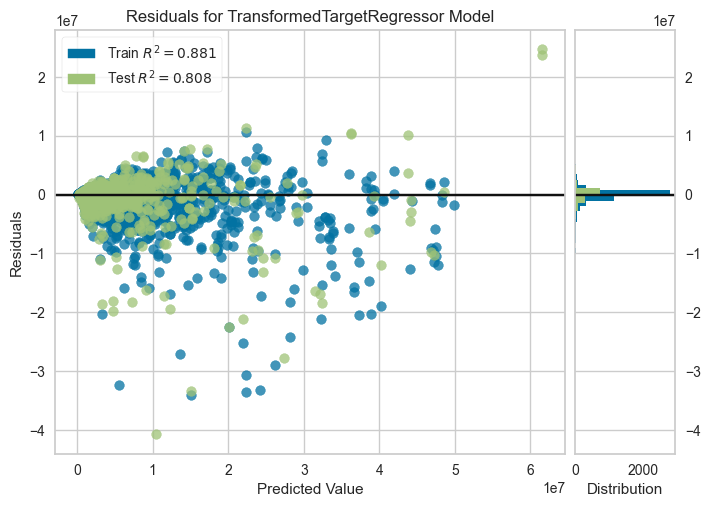

In [450]:
residual_plot(models, x_train, x_test, y_train, y_test)